In [1]:
import os
import io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class MNIST(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        try:
            row = self.dataframe.iloc[index]
            imgBytes = row['image']['bytes']
            image = Image.open(io.BytesIO(imgBytes)).convert('L')

            imageNp = np.array(image, dtype=np.float32).reshape(28, 28)
            paddedImage = np.zeros((32, 32), dtype=np.float32)
            paddedImage[2:30, 2:30] = imageNp

            normalizedImage = (paddedImage / 127.5) - 1.0

            inputTensor = torch.from_numpy(normalizedImage).unsqueeze(0)
            label = int(row['label'])

            if self.transform:
                # Convert numpy array to PIL Image to apply transforms
                imgPil = Image.fromarray(normalizedImage)
                inputTensor = self.transform(imgPil)

            return inputTensor, label
        except Exception as exception:
            print(f"Error at index {index}: {exception}")
            raise exception

transform = transforms.Compose([
    transforms.RandomApply([transforms.RandomRotation(15)], p=0.5),  
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)), 
])


def generateDigitBitmaps():
    baseTemplates = {
        0: [
            "  ###      ",
            " #   #     ",
            " #   #     ",
            " #   #     ",
            " #   #     ",
            "  ###      ",
            "           "
        ],
        1: [
            "    #      ",
            "   ##      ",
            "    #      ",
            "    #      ",
            "    #      ",
            "    #      ",
            "           "
        ],
        2: [
            "  ###      ",
            " #   #     ",
            "     #     ",
            "   ##      ",
            "  #        ",
            " #####     ",
            "           "
        ],
        3: [
            "  ###      ",
            " #   #     ",
            "     #     ",
            "   ##      ",
            "     #     ",
            " #   #     ",
            "  ###      "
        ],
        4: [
            "    #      ",
            "   ##      ",
            "  # #      ",
            " #  #      ",
            " #####     ",
            "    #      ",
            "    #      "
        ],
        5: [
            " #####     ",
            " #         ",
            " ####      ",
            "     #     ",
            "     #     ",
            " #   #     ",
            "  ###      "
        ],
        6: [
            "  ###      ",
            " #         ",
            " #         ",
            " ####      ",
            " #   #     ",
            " #   #     ",
            "  ###      "
        ],
        7: [
            " #####     ",
            "     #     ",
            "    #      ",
            "    #      ",
            "   #       ",
            "   #       ",
            "           "
        ],
        8: [
            "  ###      ",
            " #   #     ",
            " #   #     ",
            "  ###      ",
            " #   #     ",
            " #   #     ",
            "  ###      "
        ],
        9: [
            "  ###      ",
            " #   #     ",
            " #   #     ",
            "  ####     ",
            "     #     ",
            "     #     ",
            "  ###      "
        ]
    }

    def pad_row(row):
        return row.ljust(12)

    bitmaps = []
    for digit in range(10):
        template = [pad_row(row) for row in baseTemplates[digit]]
        bitmap = [[1 if char == "#" else -1 for char in row] for row in template]
        bitmaps.append(torch.tensor(bitmap, dtype=torch.float32).flatten())

    return torch.stack(bitmaps)

class LeNet5Model(nn.Module):
    def __init__(self):
        super(LeNet5Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0, bias=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0, bias=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0, bias=True)
        self.fc1 = nn.Linear(120, 84, bias=True)
        self.fc2 = nn.Linear(84, 10, bias=True)
        #self.fc2 = nn.Linear(84, 84, bias=True)
        self.act = nn.ReLU() 
        self.dropout = nn.Dropout(0.6) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act(x)
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        x = self.dropout(x) 
        x = self.fc2(x)
        return x



class StochasticDiagonalLevenbergMarquardt(optim.Optimizer):
    def __init__(self, parameters, lr=0.01, mu=1e-3, eta=1e-2):
        defaults = {'lr': lr, 'mu': mu, 'eta': eta}
        super(StochasticDiagonalLevenbergMarquardt, self).__init__(parameters, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            mu = group['mu']
            for param in group['params']:
                if param.grad is None:
                    continue
                grad = param.grad.data
                state = self.state[param]
                if 'hessianDiag' not in state:
                    state['hessianDiag'] = torch.zeros_like(param.data)
                hessianDiag = state['hessianDiag']
                hessianDiag.add_(grad ** 2)
                adaptiveLr = lr / (mu + hessianDiag.sqrt())
                param.data -= adaptiveLr * grad

        return loss


class MAPLossFunction(nn.Module):

    def __init__(self, j: float = 0.1):
        super(MAPLossFunction, self).__init__()
        self.j = j

    def forward(self, outputs, targets):
        penalties = F.log_softmax(-outputs, dim=1)
        correctClassPenalty = penalties[range(len(targets)), targets]
        expOtherClasses = torch.exp(-penalties).sum(dim=1)
        jTensor = torch.tensor(self.j, device=outputs.device)  
        competitivePenalty = torch.log(torch.exp(-jTensor) + expOtherClasses)
        mapLoss = correctClassPenalty + competitivePenalty
        return mapLoss.mean()


def evaluateRbf(model, loader, targetVectors):
    model.eval()
    total = 0
    correct = 0
    predictions, targets = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  
            probs = F.softmax(outputs, dim=1)  
            preds = probs.argmax(dim=1)  
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            predictions.append(preds.cpu())
            targets.append(labels.cpu())
    return correct / total, torch.cat(predictions), torch.cat(targets)



def train(model, trainLoader, testLoader, targetVectors, epochs, optimizer, lossFunction):
    trainErrors, testErrors = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        runningLoss = 0.0

        for inputs, labels in trainLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(inputs)
            loss = lossFunction(predictions, labels)
            loss.backward()
            optimizer.step()
            runningLoss += loss.item() * inputs.size(0)
            

        trainAcc, _, _ = evaluateRbf(model, trainLoader, targetVectors)
        testAcc, testPredictions, testTargets = evaluateRbf(model, testLoader, targetVectors)

        trainErrors.append(1 - trainAcc)
        testErrors.append(1 - testAcc)

        print(f"Epoch {epoch}, Loss: {runningLoss / len(trainLoader.dataset):.4f}, Train Accuracy: {trainAcc:.4f}, Test Accuracy: {testAcc:.4f}")

    print("Training completed.")
    return trainErrors, testErrors, testPredictions, testTargets


def confusionMatrix(predictions, targets):
    matrix = torch.zeros(10, 10, dtype=torch.int64)
    for prediction, target in zip(predictions, targets):
        matrix[target, prediction] += 1
    return matrix


if __name__ == "__main__":

    dfTrain = data.df_train  
    dfTest = data.df_test    

    trainDataset = MNIST(dfTrain, transform=transform)
    testDataset = MNIST(dfTest, transform=None) 

    trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True, num_workers=0)
    testLoader = DataLoader(testDataset, batch_size=64, shuffle=False, num_workers=0)

    print("Initializing model...")
    digitBitmaps = generateDigitBitmaps().to(device)
    model = LeNet5Model().to(device)
    #optimizer = StochasticDiagonalLevenbergMarquardt(model.parameters(), lr=0.01, mu=1e-3, eta=1e-2)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    #lossFunction = MAPLossFunction(j=0.1)
    lossFunction = nn.CrossEntropyLoss()

    trainErrors, testErrors, testPredictions, testTargets = train(
        model, trainLoader, testLoader, digitBitmaps, epochs=20, optimizer=optimizer, lossFunction=lossFunction
    )

    print(f"Final Train Error at epoch {len(trainErrors)}: {trainErrors[-1] * 100:.2f}%")
    print(f"Final Test Error at epoch {len(testErrors)}: {testErrors[-1] * 100:.2f}%")


Using device: cuda
Initializing model...
Epoch 1, Loss: 0.6697, Train Accuracy: 0.9092, Test Accuracy: 0.9560
Epoch 2, Loss: 0.2697, Train Accuracy: 0.9403, Test Accuracy: 0.9614
Epoch 3, Loss: 0.2068, Train Accuracy: 0.9489, Test Accuracy: 0.9708
Epoch 4, Loss: 0.1782, Train Accuracy: 0.9581, Test Accuracy: 0.9747
Epoch 5, Loss: 0.1637, Train Accuracy: 0.9556, Test Accuracy: 0.9639
Epoch 6, Loss: 0.1508, Train Accuracy: 0.9638, Test Accuracy: 0.9684
Epoch 7, Loss: 0.1410, Train Accuracy: 0.9647, Test Accuracy: 0.9741
Epoch 8, Loss: 0.1380, Train Accuracy: 0.9708, Test Accuracy: 0.9787
Epoch 9, Loss: 0.1289, Train Accuracy: 0.9687, Test Accuracy: 0.9772
Epoch 10, Loss: 0.1250, Train Accuracy: 0.9691, Test Accuracy: 0.9778
Epoch 11, Loss: 0.1172, Train Accuracy: 0.9706, Test Accuracy: 0.9791
Epoch 12, Loss: 0.1173, Train Accuracy: 0.9680, Test Accuracy: 0.9735
Epoch 13, Loss: 0.1150, Train Accuracy: 0.9710, Test Accuracy: 0.9756
Epoch 14, Loss: 0.1107, Train Accuracy: 0.9693, Test Accur

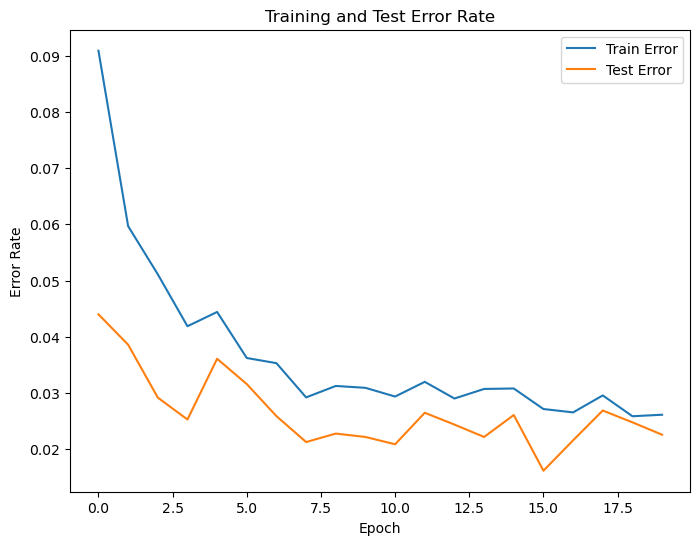

In [2]:
plt.figure(figsize=(8, 6))
plt.plot(trainErrors, label="Train Error")
plt.plot(testErrors, label="Test Error")
plt.xlabel("Epoch")
plt.ylabel("Error Rate")
plt.title("Training and Test Error Rate")
plt.legend()
plt.show()

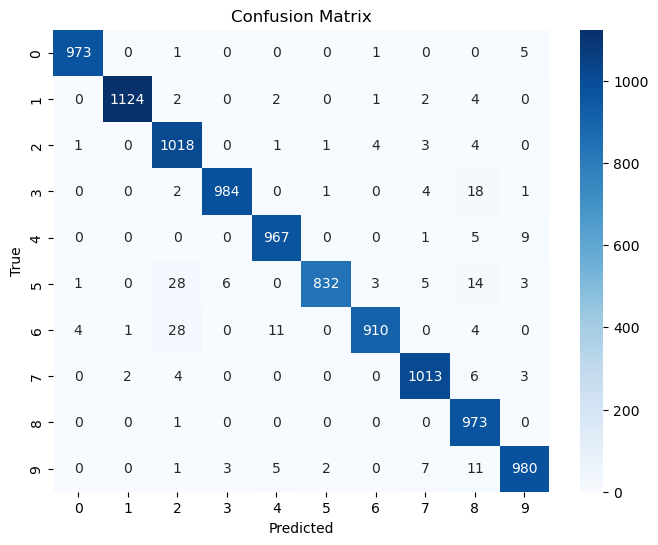

In [3]:
confusionMat = confusionMatrix(testPredictions, testTargets)
plt.figure(figsize=(8, 6))
sns.heatmap(confusionMat.numpy(), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

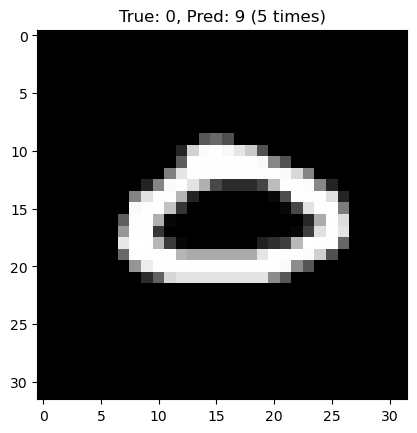

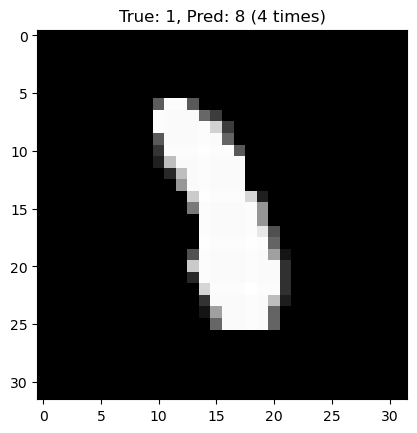

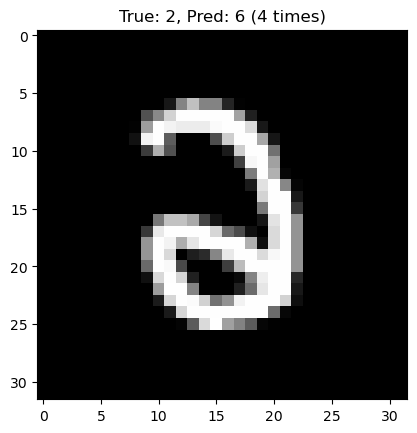

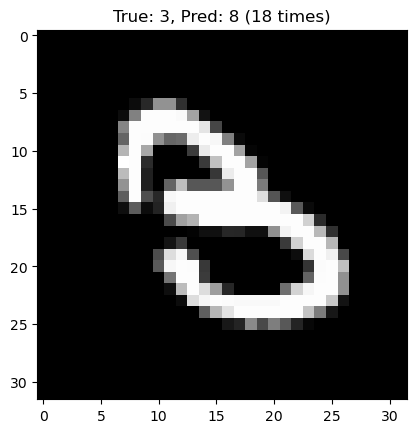

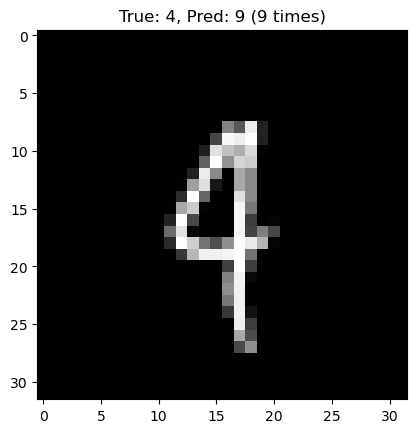

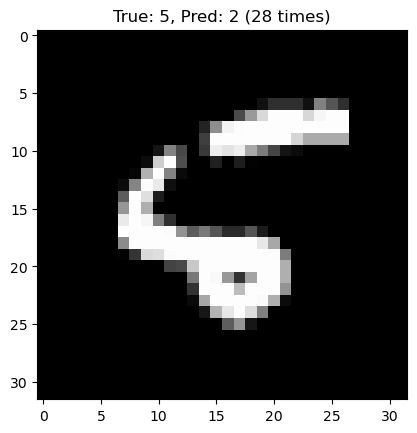

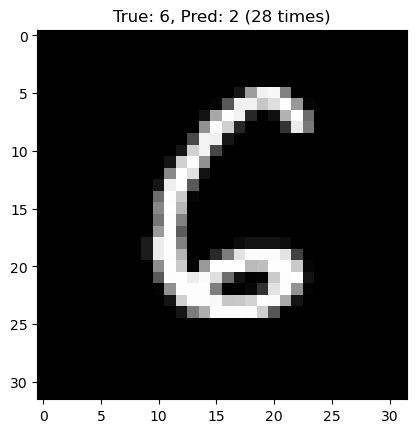

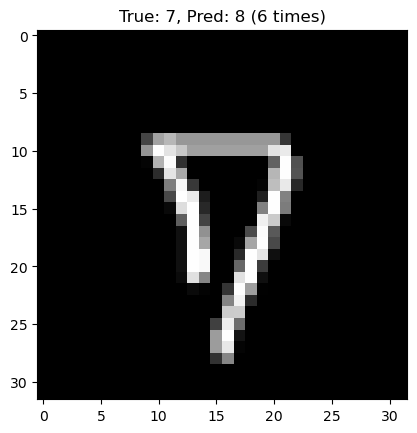

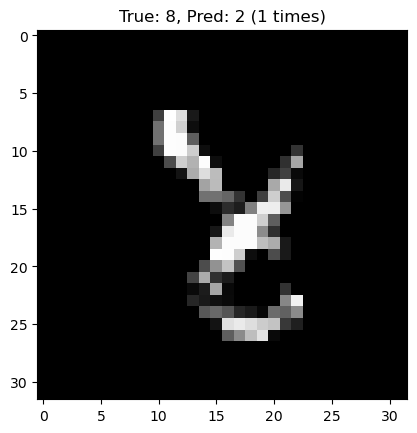

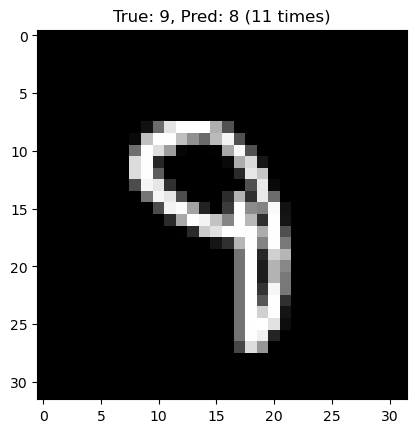

In [4]:
misclassifiedCounts = {i: {j: 0 for j in range(10)} for i in range(10)}
examples = {i: {j: None for j in range(10)} for i in range(10)}

with torch.no_grad():
    for i in range(len(testDataset)):
        inputTensor, label = testDataset[i]
        inputTensor = inputTensor.unsqueeze(0).to(device)

        outputTensor = model(inputTensor)
            
        prediction = outputTensor.argmax(dim=1).item()  

        if prediction != label:
            misclassifiedCounts[label][prediction] += 1
            if examples[label][prediction] is None:
                examples[label][prediction] = inputTensor.cpu()

for trueLabel in range(10):
    maxMisclassified = max(misclassifiedCounts[trueLabel], key=misclassifiedCounts[trueLabel].get)
    count = misclassifiedCounts[trueLabel][maxMisclassified]

    if count == 0:
        print(f"No misclassifications for digit {trueLabel}")
    else:
        example = examples[trueLabel][maxMisclassified]
        plt.imshow(example.squeeze().numpy(), cmap="gray")
        plt.title(f"True: {trueLabel}, Pred: {maxMisclassified} ({count} times)")
        plt.show()